## SETUP

In [26]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from scipy.stats import linregress
from astropy import units as u
from astropy.constants import M_jup, M_earth

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [27]:
df = pd.read_csv(r'data_cleaned/merged_GLSfitted.csv')

# Remove all rows with Nbest = 2 and delta_BIC < 10
bad_stars = df.loc[(df['delta_bic'] < 10), 'star_name'].unique()
df = df[~df['star_name'].isin(bad_stars)].reset_index(drop=True)
# Remove all rows with invalid MMR
df = df.dropna(subset=['MMR']).reset_index(drop=True)

df

,name_exoplanet.eu,star_name,name_exoclock+holczer,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,mass,mass_error,radius,...,best_model,TTV_strength,scatter,bic0,bic1,delta_bic,fap,sampled_f,flag_outside_search_range,flag_insufficient_power
0,HAT-P-26 b,HAT-P-26,HAT-P-26b,2.457197e+06,0.00007,4.234501,3.200000e-07,0.058500,0.007170,0.5700,...,sinusoidal,no_TTV,0.892727,93.556893,78.505603,15.051290,1.163037e-02,6134.0,0.0,1.0
1,HAT-P-26 d,HAT-P-26,NaN,NaN,NaN,NaN,NaN,0.020569,0.003319,0.1758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HAT-P-27 Ac,HAT-P-27 A,NaN,NaN,NaN,NaN,NaN,0.066608,0.016082,0.3863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HAT-P-27 Ab,HAT-P-27 A,HAT-P-27b,2.457645e+06,0.00014,3.039578,2.400000e-07,0.660000,0.033000,1.0550,...,sinusoidal,no_TTV,0.605749,55.152519,43.629508,11.523011,1.860868e-01,8149.0,0.0,1.0
4,HD 152843 b,HD 152843,HD152843b,2.459041e+06,0.00170,11.620740,1.100000e-04,0.030900,0.000530,0.2721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,TOI-1130 c,TOI-1130,TOI-1130c,2.459535e+06,0.00130,8.349596,1.500000e-05,1.057000,0.016000,1.1600,...,sinusoidal,no_TTV,0.732149,43.285021,18.856435,24.428586,1.836001e-04,5000.0,0.0,0.0
298,TOI-216 b,TOI-216,TOI-216.02,2.459202e+06,0.16000,17.201900,6.600000e-03,0.055800,0.002000,0.6861,...,sinusoidal,no_TTV,1.882255,752.935255,306.113185,446.822070,5.821047e-98,5000.0,0.0,0.0
299,TOI-216 c,TOI-216,TOI-216.01,2.458953e+06,0.03500,34.506000,2.400000e-03,0.528000,0.020000,0.9010,...,sinusoidal,weak,2.563454,341.504061,11.272756,330.231305,1.542950e-72,5000.0,0.0,0.0
300,WASP-148 b,WASP-148,WASP-148b,2.458583e+06,0.00120,8.803812,1.000000e-05,0.287000,0.022000,0.7560,...,sinusoidal,no_TTV,0.910502,106.876943,23.735943,83.140999,1.512229e-17,5000.0,0.0,0.0


In [28]:
df.groupby('star_name')['planet_pos'].nunique().value_counts()

planet_pos
2    151
Name: count, dtype: int64

## CALC

In [29]:
def analytic_TTV_invert(df_full, star_name):
    # Take only specific star
    df = df_full[df_full.star_name == star_name]

    inner = (df['planet_pos'] == 1)
    outer = (df['planet_pos'] == 2)

    # Boolean flag
    has_inner_TTV = df.loc[inner, 'Pttv'].notna().any()
    has_outer_TTV = df.loc[outer, 'Pttv'].notna().any()

    # Complex eccentricity
    e_inner = df.loc[inner, 'eccentricity'].iloc[0]
    e_outer = df.loc[outer, 'eccentricity'].iloc[0]
    w_inner = df.loc[inner, 'omega'].iloc[0]
    w_outer = df.loc[outer, 'omega'].iloc[0]
    z = natsume.get_ComplexEccentricities(e_inner, w_inner, e_outer, w_outer)
    # MMR
    MMR = df.loc[outer, 'MMR'].iloc[0]
    # Orbital periods
    Porb_inner = df.loc[inner, 'orbital_period'].iloc[0]
    Porb_outer = df.loc[outer, 'orbital_period'].iloc[0]
    # Stellar mass
    Mstar = df.loc[inner, 'star_mass'].iloc[0]
    
    # Calculate outer mass from inner TTV
    if has_inner_TTV == True:
        Pttv_inner = df.loc[inner, 'Pttv'].iloc[0]
        Attv_inner = df.loc[inner, 'Attv'].iloc[0]
        TTV_inner = natsume.get_TTVSineCurve(amplitude=Attv_inner, superperiod=Pttv_inner)

        mu_outer = natsume.EstimateOuterMass(
           innerTTV=TTV_inner,
           inner_period=Porb_inner,
           mmr=MMR,
           eccentricity=z,
           outer_period=Porb_outer
        )
        m_outer = (mu_outer * Mstar*u.M_sun).to(u.M_jup).value
        m_outer_err = np.nan
    elif has_inner_TTV == False:
        m_outer, m_outer_err = np.nan, np.nan
        
    if has_outer_TTV == True:
        Pttv_outer = df.loc[outer, 'Pttv'].iloc[0]
        Attv_outer = df.loc[outer, 'Attv'].iloc[0]
        TTV_outer = natsume.get_TTVSineCurve(amplitude=Attv_outer, superperiod=Pttv_outer)
        
        mu_inner = natsume.EstimateInnerMass(
           outerTTV=TTV_outer,
           outer_period=Porb_outer,
           mmr=MMR,
           eccentricity=z,
           inner_period=Porb_inner
        )
        m_inner = (mu_inner * Mstar*u.M_sun).to(u.M_jup).value
        m_inner_err = np.nan
    elif has_outer_TTV == False:
        m_inner, m_inner_err = np.nan, np.nan

    return m_inner, m_inner_err, m_outer, m_outer_err

In [30]:
df_final = df.copy()
calculated_cols = ['mcalc', 'mcalc_err']
df_final[calculated_cols] = np.nan

all_stars = df_final['star_name'].dropna().astype(str).unique()
for star in tqdm(all_stars):
    mcalc_inner, mcalc_err_inner, mcalc_outer, mcalc_err_outer = analytic_TTV_invert(df_final, star)
    # Insert to df
    mask_inner = (df_final['star_name'] == star) & (df_final['planet_pos'] == 1)
    mask_outer = (df_final['star_name'] == star) & (df_final['planet_pos'] == 2)
    df_final.loc[mask_inner, calculated_cols] = [mcalc_inner, mcalc_err_inner]
    df_final.loc[mask_outer, calculated_cols] = [mcalc_outer, mcalc_err_outer]

EXPORT_FILENAME = r'data_cleaned/merged_2planet_calculated.csv'
df_final.to_csv(EXPORT_FILENAME, index=False)
df_final.head(3)

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [00:02<00:00, 68.06it/s]


,name_exoplanet.eu,star_name,name_exoclock+holczer,T0_(BJD_TDB),T0_unc.,P_(days),P_unc.,mass,mass_error,radius,...,scatter,bic0,bic1,delta_bic,fap,sampled_f,flag_outside_search_range,flag_insufficient_power,mcalc,mcalc_err
0,HAT-P-26 b,HAT-P-26,HAT-P-26b,2.457197e+06,0.00007,4.234501,3.200000e-07,0.058500,0.007170,0.5700,...,0.892727,93.556893,78.505603,15.05129,0.01163,6134.0,0.0,1.0,NaN,NaN
1,HAT-P-26 d,HAT-P-26,NaN,NaN,NaN,NaN,NaN,0.020569,0.003319,0.1758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004344,NaN
2,HAT-P-27 Ac,HAT-P-27 A,NaN,NaN,NaN,NaN,NaN,0.066608,0.016082,0.3863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384538,NaN


## PLOT

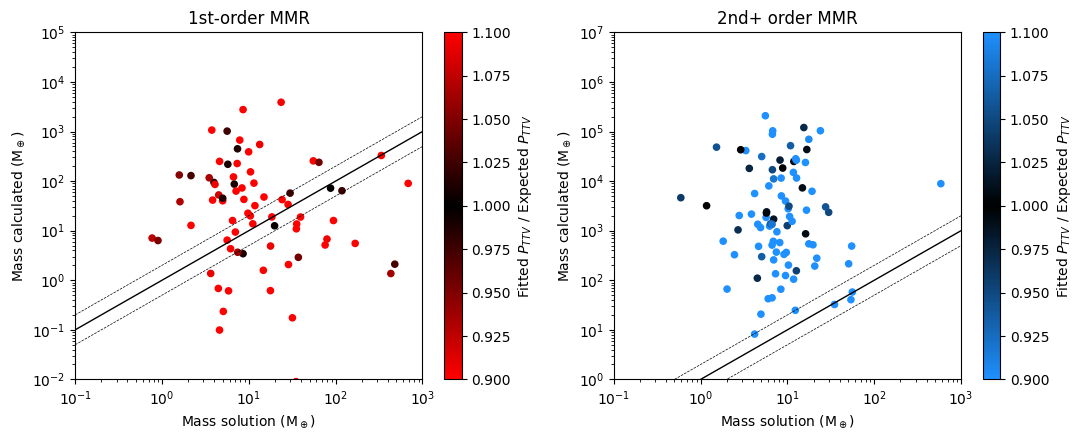

In [31]:
# Variable setup
N1 = (df_final.N == 1); N2 = (df_final.N != 1)
msol1, mcalc1 = df_final[N1].mass, df_final[N1].mcalc
msol2, mcalc2 = df_final[N2].mass, df_final[N2].mcalc

def convert_Mjup_to_Mearth_arr(Series):
    return (Series.to_numpy() * u.M_jup).to(u.M_earth)
msol1, mcalc1 = convert_Mjup_to_Mearth_arr(msol1), convert_Mjup_to_Mearth_arr(mcalc1) 
msol2, mcalc2 = convert_Mjup_to_Mearth_arr(msol2), convert_Mjup_to_Mearth_arr(mcalc2) 

Pttv_deviation1 = df_final[N1].Pttv / df_final[N1].expected_Pttv
Pttv_deviation2 = df_final[N2].Pttv / df_final[N2].expected_Pttv

# Colormap setup
def cmap(color):
    return LinearSegmentedColormap.from_list(
        'cmap',
        [f'{color}', 'black', f'{color}']
    )

# Plot
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
vmin, vmax = 0.9, 1.1
def plot_baseline(ax, xlim):
    ax.plot(xlim, xlim, color='black', lw=1)
    ax.plot(xlim, xlim * 2, color='black', ls='--', lw=.5)
    ax.plot(xlim, xlim / 2, color='black', ls='--', lw=.5)
# ---------- 1st order ----------
xlim = np.array([1e-1, 1e3]); ylim = np.array([1e-2, 1e5])
ax = axes[0]
plot_baseline(ax, xlim)
sc1 = ax.scatter(
    msol1, mcalc1,
    c=Pttv_deviation1,
    cmap=cmap('red'), vmin=vmin, vmax=vmax,
    s=20
)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.set_title('1st-order MMR')
ax.set_xlabel('Mass solution (M$_\oplus$)')
ax.set_ylabel('Mass calculated (M$_\oplus$)')
fig.colorbar(sc1, ax=ax, label=r'Fitted $P_{TTV}$ / Expected $P_{TTV}$')

# ---------- 2nd+ order ----------
xlim = np.array([1e-1, 1e3]); ylim = np.array([1e+0, 1e+7])
ax = axes[1]
plot_baseline(ax, xlim)
sc2 = ax.scatter(
    msol2, mcalc2,
    c=Pttv_deviation2,
    cmap=cmap('dodgerblue'), vmin=vmin, vmax=vmax,
    s=20
)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.set_title('2nd+ order MMR')
ax.set_xlabel('Mass solution (M$_\oplus$)')
ax.set_ylabel('Mass calculated (M$_\oplus$)')
fig.colorbar(sc2, ax=ax, label=r'Fitted $P_{TTV}$ / Expected $P_{TTV}$')

plt.tight_layout()
plt.show()